In [1]:
!wget -O imdb.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1vrQ5czMHoO3pEnmofFskymXMkq_u1dPc"
!unzip imdb.zip
!pip -q install eli5
!pip -q install spacy
!python -m spacy download en

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"unzip" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


     --------------------------------------- 12.8/12.8 MB 31.2 MB/s eta 0:00:00
[!] As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the full
pipeline package name 'en_core_web_sm' instead.
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


2022-11-02 21:20:43.952622: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudnn64_8.dll'; dlerror: cudnn64_8.dll not found
2022-11-02 21:20:43.952676: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# Классификация текстов

Начнём с самого простого - анализа тональности текста.

Будем классифицировать отзывы с IMDB на положительные/отрицательные.

Датасет взят с http://ai.stanford.edu/~amaas/data/sentiment/

In [2]:
!head train.tsv

"head" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [3]:
import pandas as pd

train_df = pd.read_csv("train.tsv", delimiter="\t")
test_df = pd.read_csv("test.tsv", delimiter="\t")

print('Train size = {}'.format(len(train_df)))
print('Test size = {}'.format(len(test_df)))

Train size = 25000
Test size = 25000


In [4]:
import nltk
stop_words_nltk = nltk.corpus.stopwords.words('english')
stop_words_nltk

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [5]:
train_df['review'] = [' '.join([w for w in x.split() if len(w)>2]) for x in train_df.review]
train_df

,is_positive,review
0,0,"Dreamgirls, despite its fistful Tony wins incr..."
1,0,This show comes with interesting locations fas...
2,1,"simply love this movie. also love the Ramones,..."
3,0,Spoilers ahead you want call them that...<br /...
4,1,all-time favorite movie! have seen many movies...
...,...,...
24995,1,"big fan the movie, but not for the usual reaso..."
24996,0,I'm not going bother with plot synopsis since ...
24997,0,This movie don't know. Why they would take suc...
24998,1,Saw this film DVD yesterday and was gob-smacke...


Посмотрите глазами на тексты? Какие есть зацепки, как определить, что это за сентимент?

Самое простое, как всегда - найти ключевые слова.

In [6]:
#@title Начинаем классифицировать! { vertical-output: true, display-mode: "form" }
positive_words = 'love', 'great', 'best', 'wonderful' #@param {type:"raw"}
negative_words = 'worst', 'awful', '1/10', 'crap' #@param {type:"raw"}

positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))
if accuracy > 0.71:
    from IPython.display import Image, display
    display(Image('https://s3.amazonaws.com/achgen360/t/rmmoZsub.png', width=500))

Test accuracy = 66.73%


**Задание** Придумайте хорошие ключевые слова или фразы и наберите хотя бы 71% точности на тесте (и не забудьте посмотреть на код классификации!)

**Задание** Кому-нибудь нравятся эти `<br /><br />`? Лично мне - нет. Напишите регулярку, которая будет их удалять

In [7]:
import re

pattern = re.compile('<br />')

print(train_df['review'].iloc[3])
print(pattern.subn(' ', train_df['review'].iloc[3])[0])

Spoilers ahead you want call them that...<br /><br />I would almost recommend this film just people can truly see 1/10. Where begin, we'll start from the top...<br /><br />THE STORY: Don't believe the premise the movie has nothing with abandoned cars, and people finially understanding what the mysterious happenings are. It's draub, basic, cabin movie with intensity "effort".<br /><br />THE SCREENPLAY: usually give credit indie screenwriters, it's hard work when you are starting out...but this crap. The story flat leaves you emotionless the entire movie. The dialogue extremely weak and predictable boasting lines "Woah, you totally freaked out" and was wondering you'd uh...if you'd like to..uh, would you come the cabin with me?". makes want rip out all hair, one strand time and feed myself.<br /><br />THE CHARACTERS: HOLY CRAP!!!! Some have described the characters flat, want take one step further and say that they actually have reverse character arch.. They actually start working parall

Применим ее:

In [8]:
train_df['review'] = train_df['review'].apply(lambda text: pattern.subn(' ', text)[0])
test_df['review'] = test_df['review'].apply(lambda text: pattern.subn(' ', text)[0])

Получилось что надо.

Запустим теперь её на реальных данных.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

dummy_data = ['The movie was excellent',
              'the movie was awful']

dummy_matrix = vectorizer.fit_transform(dummy_data)

print(dummy_matrix.toarray())
print(vectorizer.get_feature_names())

[[0 1 1 1 1]
 [1 0 1 1 1]]
['awful', 'excellent', 'movie', 'the', 'was']


C:\Users\nikit\.conda\envs\NLP\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [10]:
vectorizer = CountVectorizer()
vectorizer.fit(train_df['review'].values)

CountVectorizer()

In [11]:
vectorizer.get_feature_names()

['00',
 '000',
 '0000000000001',
 '00001',
 '00015',
 '000s',
 '001',
 '003830',
 '006',
 '007',
 '0079',
 '0080',
 '0083',
 '0093638',
 '00am',
 '00pm',
 '00s',
 '01',
 '01pm',
 '02',
 '020410',
 '029',
 '03',
 '04',
 '041',
 '05',
 '050',
 '06',
 '06th',
 '07',
 '08',
 '087',
 '089',
 '08th',
 '09',
 '0ne',
 '10',
 '100',
 '1000',
 '1000000',
 '10000000000000',
 '1000lb',
 '1000s',
 '1001',
 '100b',
 '100k',
 '100m',
 '100min',
 '100mph',
 '100s',
 '100th',
 '100x',
 '100yards',
 '101',
 '101st',
 '102',
 '102nd',
 '103',
 '104',
 '1040',
 '1040a',
 '1040s',
 '105',
 '1050',
 '105lbs',
 '106',
 '106min',
 '107',
 '108',
 '109',
 '10am',
 '10lines',
 '10mil',
 '10min',
 '10minutes',
 '10p',
 '10pm',
 '10s',
 '10star',
 '10th',
 '10x',
 '10yr',
 '11',
 '110',
 '1100',
 '11001001',
 '1100ad',
 '111',
 '112',
 '1138',
 '114',
 '1146',
 '115',
 '116',
 '117',
 '11f',
 '11m',
 '11th',
 '12',
 '120',
 '1200',
 '1200f',
 '1201',
 '1202',
 '123',
 '12383499143743701',
 '125',
 '125m',
 '127',

In [12]:
vectorizer.transform([train_df['review'].iloc[3]])

<1x74721 sparse matrix of type '<class 'numpy.int64'>'
	with 191 stored elements in Compressed Sparse Row format>

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

dummy_data = ['The movie was excellent',
              'the movie was awful']
dummy_labels = [1, 0]

vectorizer = CountVectorizer(stop_words=stop_words_nltk)
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(dummy_data, dummy_labels)

print(vectorizer.get_feature_names())
print(classifier.coef_)

['awful', 'excellent', 'movie']
[[-0.40104279  0.40104279  0.        ]]


C:\Users\nikit\.conda\envs\NLP\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [14]:
model.fit(train_df['review'], train_df['is_positive'])

C:\Users\nikit\.conda\envs\NLP\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('classifier', LogisticRegression())])

In [15]:
from sklearn.metrics import accuracy_score

def eval_model(model, test_df):
    preds = model.predict(test_df['review'])
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))
    
eval_model(model, test_df)

Test accuracy = 86.25%


Прогресс!

Хочется как-то посмотреть, что заинтересовало классификатор. К счастью, сделать это совсем просто:

In [16]:
import eli5
eli5.show_weights(classifier, vec=vectorizer, top=40)

C:\Users\nikit\.conda\envs\NLP\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight?,Feature
+1.579,refreshing
+1.548,wonderfully
+1.413,funniest
+1.357,superb
+1.328,carrey
+1.295,surprisingly
+1.283,perfect
+1.280,flawless
+1.269,excellent
+1.239,vengeance


Посмотрим на конкретные примеры его работы:

In [17]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [18]:
print('Positive' if test_df['is_positive'].iloc[6] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[6], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


C:\Users\nikit\.conda\envs\NLP\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Посмотрим на примеры неправильной классификации, наконец:

In [19]:
import numpy as np

preds = model.predict(test_df['review'])
incorrect_pred_index = np.random.choice(np.where(preds != test_df['is_positive'])[0])

eli5.show_prediction(classifier, test_df['review'].iloc[incorrect_pred_index],
                     vec=vectorizer, targets=['positive'], target_names=['negative', 'positive'])

C:\Users\nikit\.conda\envs\NLP\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Придумываем новые признаки

### Tf-idf

Сейчас мы на все слова смотрим с одинаковым весом - хотя какие-то из них более редкие, какие-то более частые, и эта частотность - полезная, вообще говоря, информация.

Самый простой способ добавить статистическую информацию о частотностях - сделать *tf-idf* взвешивание:

$$\text{tf-idf}(t, d) = \text{tf}(t, d) \times \text{idf}(t)$$

*tf* - term-frequency - частотность слова `t` в конкретном документе `d` (рецензии в нашем случае). Это ровно то, что мы уже считали.

*idf* - inverse document-frequency - коэффициент, который тем больше, чем в меньшем числе документов встречалось данное слово. Считается как-нибудь так:
$$\text{idf}(t) = \text{log}\frac{1 + n_d}{1 + n_{d(t)}} + 1$$
где $n_d$ - число всех документов, а $n_{d(t)}$ - число документов со словом `t`.

Использовать его просто - нужно заменить `CountVectorizer` на `TfidfVectorizer`.

**Задание** Попробуйте запустить `TfidfVectorizer`. Посмотрите на ошибки, которые он научился исправлять, и на ошибки, которые он начал делать - по сравнению с `CountVectorizer`.

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words=stop_words_nltk)
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.33%


### N-граммы слов

До сих пор мы смотрели на тексты как на мешок слов - но очевидно, что есть разница между `good movie` и `not good movie`.

Добавим информацию (хоть какую-то) о последовательностях слов - будем извлекать еще и биграммы слов.

В Vectorizer'ах для этого есть параметр `ngram_range=(n_1, n_2)` - он говорит, что нужны n_1-...n_2-граммы.

**Задание** Попробуйте увеличенный range и поинтерпретируйте полученный результат.

In [21]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words=stop_words_nltk)
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.08%


### N-граммы символов

Символьные n-граммы дают простой способ выучить полезные корни и суффиксы, не связываясь с этой вашей лингвистикой - только статистика, только хардкор.

Например, слово `badass` мы можем представить в виде такой последовательности триграмм:

`##b #ba bad ada das ass ss# s##`

So interpretable, неправда ли?

Реализовать это дело всё так же просто - нужно поставить `analyzer='char'` в вашем любимом Vectorizer'е и выбрать размер `ngram_range`.

**Задание** Запилите классификатор на n-граммах символов и визуализируйте его.

In [22]:
vectorizer = TfidfVectorizer(ngram_range=(2, 6), max_features=20000, analyzer='char')
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

C:\Users\nikit\.conda\envs\NLP\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test accuracy = 87.76%


In [23]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


C:\Users\nikit\.conda\envs\NLP\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Подключаем лингвистику

### Лемматизация и стемминг

Если присмотреться, можно найти формы одного слова с разной семантической окраской по мнению классификатора. Или нет?

**Задание** Найти формы слова с разной семантической окраской.

Поверя, что они есть, попробуем что-нибудь с этим сделать.

Например, лемматизируем - сведем к начальной форме все слова. Поможет в этом библиотека spacy.

In [24]:
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_sm', disable=['parser'])


C:\Users\nikit\AppData\Roaming\Python\Python39\site-packages\spacy\language.py:1895: UserWarning: [W123] Argument disable with value ['parser'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  warnings.warn(


In [25]:
%%time
docs_train = [doc for doc in nlp.pipe(train_df.review.values)]

CPU times: total: 0 ns
Wall time: 0 ns


In [26]:
docs_train

[Dreamgirls, despite its fistful Tony wins incredibly weak year Broadway, has never been what one would call jewel the crown stage musicals. However, that not say that the right cinematic hands could not fleshed out and polished into something worthwhile on-screen. Unfortunately, what transfers the screen basically slavishly faithful version the stage hit with all its inherent weaknesses intact. First, the score has never been one the strong points this production and the film does not change that factor. There are lots songs (perhaps too many?), but few them are especially memorable. The closest any come catchy tunes are the title song and One Night Only the much acclaimed And Telling You That Not Going less great song than dramatic set piece for the character Effie (Jennifer Hudson). The film slick and technically well-produced, but the story and characters are surprisingly thin and lacking any resonance. There some interest the opening moments, watching Jamie Foxx's Svengali-like ma

In [27]:
%%time
docs_test = [doc for doc in nlp.pipe(test_df.review.values)]

CPU times: total: 0 ns
Wall time: 0 ns


In [28]:
for token in docs_train[0]:
    print(token.text, token.lemma_, token.ent_iob_, token.ent_type_)

Dreamgirls Dreamgirls B GPE
, , O 
despite despite O 
its its O 
fistful fistful O 
Tony Tony B PERSON
wins win O 
incredibly incredibly O 
weak weak O 
year year O 
Broadway Broadway B FAC
, , O 
has have O 
never never O 
been be O 
what what O 
one one O 
would would O 
call call O 
jewel jewel O 
the the O 
crown crown O 
stage stage O 
musicals musical O 
. . O 
However however O 
, , O 
that that O 
not not O 
say say O 
that that O 
the the O 
right right O 
cinematic cinematic O 
hands hand O 
could could O 
not not O 
fleshed flesh O 
out out O 
and and O 
polished polish O 
into into O 
something something O 
worthwhile worthwhile O 
on on O 
- - O 
screen screen O 
. . O 
Unfortunately unfortunately O 
, , O 
what what O 
transfers transfer O 
the the O 
screen screen O 
basically basically O 
slavishly slavishly O 
faithful faithful O 
version version O 
the the O 
stage stage O 
hit hit O 
with with O 
all all O 
its its O 
inherent inherent O 
weaknesses weakness O 
intac

In [29]:
%%time
lemmatized_text_train = [' '.join([token.lemma_ for token in doc]) for doc in docs_train]

CPU times: total: 0 ns
Wall time: 0 ns


In [30]:
%%time
#lemmatized_text_test = [' '.join([token.lemma_ for token in doc]) for doc in docs_test]

CPU times: total: 0 ns
Wall time: 0 ns


In [34]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words=stop_words_nltk)
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(lemmatized_text_train, train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 85.96%


**Задание** Сделайте классификатор на лемматизированных текстах.

Более простой способ нормализации слов - использовать стемминг. Он немного тупой, не учитывает контекст, но иногда оказывается даже эффективнее лемматизации - а, главное, быстрее.

По сути это просто набор правил, как обрезать слово, чтобы получить основу (stem):

In [35]:
from nltk import PorterStemmer

stemmer = PorterStemmer()

print(stemmer.stem('become'))
print(stemmer.stem('becomes'))
print(stemmer.stem('became'))

becom
becom
becam


**Задание** Попробуйте вместо лемм классифицировать основы.

### NER

В текстах рецензий очень много именованных сущностей. Вот, например:

In [37]:
displacy.render(docs_test[0], style='ent', jupyter=True)

Вообще говоря, почему вдруг какой-нибудь Депп должен нести семантическую окраску? Однако оказывается, что классификатор выучивает, что какие-то имена чаще в положительных рецензиях - или наоборот. Это похоже на переобучение - почему бы не попробовать вырезать сущности?

**Задание** Удалите из текстов какие-то из сущностей, пользуясь координатами из запикленных файлов. Описание сущностей можно посмотреть [здесь](https://spacy.io/api/annotation#named-entities). Запустите классификатор.

## Включаем дип лёрнинг

Мы тут пришли deep learning'ом заниматься, а делаем почему-то модель на логистической регрессии. Как так?

Попробуем запустить относительно стандартную модель для классификации текстов - сверточная сеть поверх словных эмбеддингов.

Разбираться, что это за зверь, будем на следующих занятиях, а пока будем просто им пользоваться :)

Каждое предложение нужно представлять набором слов - и сразу же начинаются проблемы. Во-первых, как ограничить длину предложения?

Прикинем по гистограмме, какая длина нам подходит:

In [38]:
train_df['review']

0        Dreamgirls, despite its fistful Tony wins incr...
1        This show comes with interesting locations fas...
2        simply love this movie. also love the Ramones,...
3        Spoilers ahead you want call them that...  I w...
4        all-time favorite movie! have seen many movies...
                               ...                        
24995    big fan the movie, but not for the usual reaso...
24996    I'm not going bother with plot synopsis since ...
24997    This movie don't know. Why they would take suc...
24998    Saw this film DVD yesterday and was gob-smacke...
24999    This was disappointment none the nuance the or...
Name: review, Length: 25000, dtype: object

<BarContainer object of 245 artists>

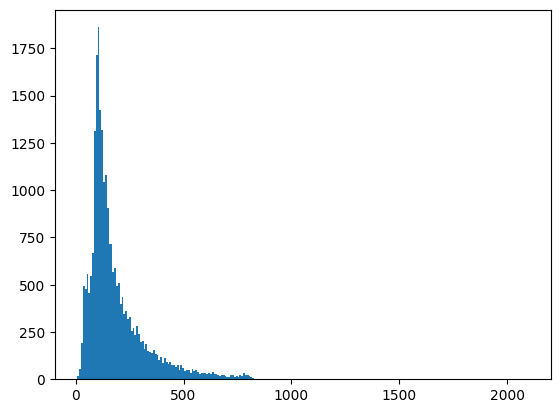

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(train_df.review.apply(lambda text: len(text.split())), bins='auto')
hist

Кроме этого, нужно перенумеровать как-то слова.

In [40]:
from collections import Counter

words_counter = Counter((word for text in train_df.review for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

Words count 26487


**Задание** Сконвертируйте данные

In [41]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)
    
    for inx, text in enumerate(texts):
        result = []
        for word in text.split():
            if word in word2idx:
                result.append(word2idx[word])
        padding = [0]*(max_text_len - len(result))
        data[inx] = np.array(padding + result[-max_text_len:], dtype=np.int)
    return data

X_train = convert(train_df.review, word2idx, 1000)
X_test = convert(test_df.review, word2idx, 1000)

C:\Users\nikit\AppData\Local\Temp\ipykernel_6256\4152861949.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = np.zeros((len(texts), max_text_len), dtype=np.int)
C:\Users\nikit\AppData\Local\Temp\ipykernel_6256\4152861949.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, c

Поставим учиться модельку на keras.

*Напоминание*: на keras, чтобы обучить модель, нужно
1. Определить модель, например:
```python 
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_dim=NUM_WORDS))
```
2. Задать функцию потерь и оптимизатор:
```python
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
```

3. Запустить обучение:
```python
model.fit(X_train, y_train, 
          batch_size=32,
          epochs=3,
          validation_data=(X_test, y_test))
```

В NLP чаще всего ставятся задачи классификации, поэтому нужно запомнить такие функции потерь:

*   **categorical_crossentropy** - для многоклассовой классификации, в качестве меток должны передаваться one-hot-encoding вектора
*   **sparse_categorical_crossentropy** - аналогично предыдущему, но в качестве меток нужно передавать просто индексы соответствующих классов
*   **binary_crossentropy** - для бинарной классификации


В качестве оптимизатора обычно используют `sgd` или `adam`.


In [42]:
import tensorflow as tf
tf.__version__

'2.10.0'

In [43]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Dropout

In [44]:
model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    GlobalMaxPooling1D(),
    Dense(units=10, activation='relu'),
    Dense(units=10, activation='relu'),

    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 64)          1695168   
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,695,939
Trainable params: 1,695,939
Non-trainable params: 0
______________________________________________

In [45]:
model.fit(X_train, train_df.is_positive, batch_size=128, epochs=10, 
          validation_data=(X_test, test_df.is_positive))

Epoch 1/10
196/196 [==============================] - 21s 103ms/step - loss: 0.5966 - accuracy: 0.7771 - val_loss: 0.4005 - val_accuracy: 0.8403
Epoch 2/10
196/196 [==============================] - 20s 103ms/step - loss: 0.3001 - accuracy: 0.8802 - val_loss: 0.3008 - val_accuracy: 0.8736
Epoch 3/10
196/196 [==============================] - 22s 111ms/step - loss: 0.1818 - accuracy: 0.9345 - val_loss: 0.2918 - val_accuracy: 0.8763
Epoch 4/10
196/196 [==============================] - 20s 102ms/step - loss: 0.1032 - accuracy: 0.9690 - val_loss: 0.3112 - val_accuracy: 0.8730
Epoch 5/10
196/196 [==============================] - 20s 104ms/step - loss: 0.0516 - accuracy: 0.9878 - val_loss: 0.3462 - val_accuracy: 0.8668
Epoch 6/10
196/196 [==============================] - 20s 105ms/step - loss: 0.0226 - accuracy: 0.9966 - val_loss: 0.3959 - val_accuracy: 0.8605
Epoch 7/10
196/196 [==============================] - 20s 103ms/step - loss: 0.0096 - accuracy: 0.9992 - val_loss: 0.4223 - val_ac

In [46]:
train_df['review']

0        Dreamgirls, despite its fistful Tony wins incr...
1        This show comes with interesting locations fas...
2        simply love this movie. also love the Ramones,...
3        Spoilers ahead you want call them that...  I w...
4        all-time favorite movie! have seen many movies...
                               ...                        
24995    big fan the movie, but not for the usual reaso...
24996    I'm not going bother with plot synopsis since ...
24997    This movie don't know. Why they would take suc...
24998    Saw this film DVD yesterday and was gob-smacke...
24999    This was disappointment none the nuance the or...
Name: review, Length: 25000, dtype: object

**Задание** Подсчитайте качество модели на тесте